In [1]:
import os
# Use only a specified GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Disable tensorflow debugging information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    multiple                  6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [4]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [5]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [6]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [7]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

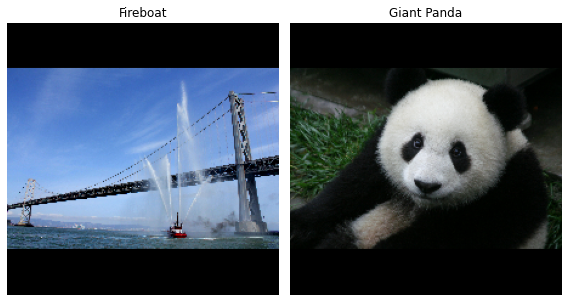

In [8]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [9]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

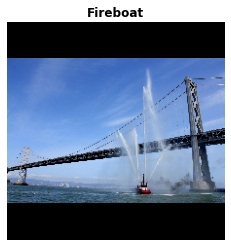

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


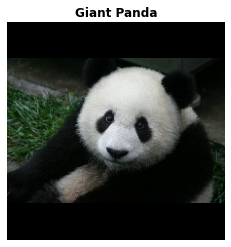

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [10]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

In [11]:
baseline = tf.zeros(shape=(224,224,3))

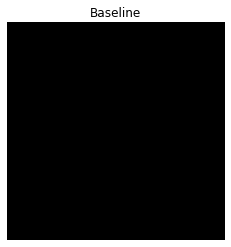

In [12]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [13]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [14]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [15]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas
)

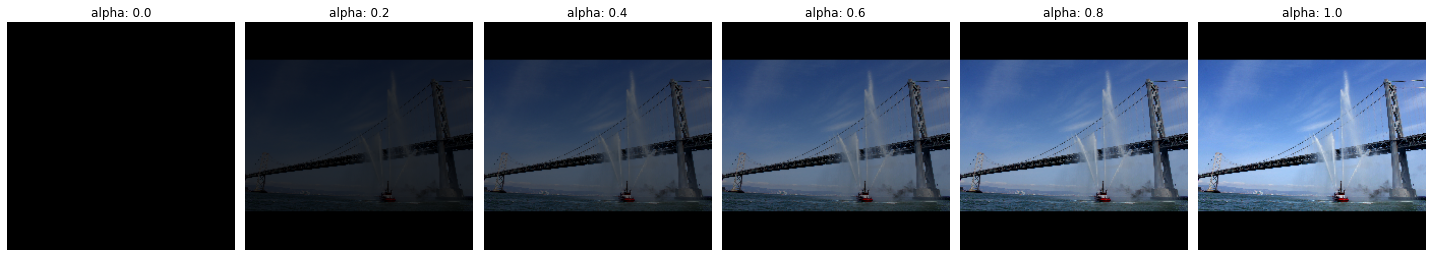

In [16]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout();

In [17]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        print("images shape:", np.shape(images))
        logits = model(images)
        print("logits shape:", np.shape(logits))
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
        print("probs shape:", np.shape(probs))
    return tape.gradient(probs, images)

In [18]:
import os
os.cpu_count()

48

In [19]:
def compute_row_gradients(image, i):
    np_images
    for j in range(np.shape(image)[1]):
        for k in range(np.shape(image)[2]):
            np_image_copy_plus = np.copy(image)
            np_image_copy_plus[:,i,j,k] += EPS
            
            np_image_copy_minus = np.copy(image)
            np_image_copy_minus[:,i,j,k] -= EPS

In [56]:
import multiprocessing
pool = multiprocessing.Pool()

Process ForkPoolWorker-132:
Traceback (most recent call last):
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'compute_positive' on <module '__main__'>
Process ForkPoolWorker-129:
AttributeError: Can't get attribute 'compute_positive' on <module '__main__'>
Traceback (most recent call last):
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ailie/anaconda3/envs/tf_env/lib/python3.7/multiproc

In [ ]:
# x_plus[i][j] = img cu pixel-ul i,j modificat
# x_minus[i][j] = img cu pixel-ul i,j modificat, shape:(224, 224, 224, 224, 3

In [27]:
from tqdm import tqdm
tasks_positive = [(i, j, k, compute_positive(i, j, k, image)) for i in tqdm(range (224)) for j in range(224) for k in range(1)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:08<00:00, 27.79it/s]


In [28]:
tasks_negative = [(i, j, k, compute_negative(i, j, k, image)) for i in tqdm(range (224)) for j in range(224) for k in range(1)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:13<00:00, 16.56it/s]


In [29]:
pos_imgs = [x[3] for x in tasks_positive]

In [30]:
neg_imgs = [x[3] for x in tasks_negative]

In [ ]:
model.predict(pos_imgs, batch_size=128)

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 213/224 [17:37<00:54,  4.97s/it]


In [24]:
EPS = 0.002
def compute_positive(i, j, k, image):
    new_image = np.copy(image)
    new_image[i, j, k] += EPS
    return new_image

def compute_negative(i, j, k, image):
    new_image = np.copy(image)
    new_image[i, j, k] -= EPS
    return new_image

In [ ]:
pool.map(compute_positive, tasks_positive)

Process ForkPoolWorker-163:
Process ForkPoolWorker-156:
Process ForkPoolWorker-160:
Process ForkPoolWorker-153:
Process ForkPoolWorker-158:
Process ForkPoolWorker-170:
Process ForkPoolWorker-149:
Process ForkPoolWorker-159:
Process ForkPoolWorker-166:
Process ForkPoolWorker-148:
Process ForkPoolWorker-155:
Process ForkPoolWorker-167:
Process ForkPoolWorker-151:
Process ForkPoolWorker-152:
Process ForkPoolWorker-145:
Process ForkPoolWorker-154:
Process ForkPoolWorker-165:
Process ForkPoolWorker-147:
Process ForkPoolWorker-168:
Process ForkPoolWorker-169:
Process ForkPoolWorker-157:
Process ForkPoolWorker-164:
Process ForkPoolWorker-150:
Process ForkPoolWorker-162:
Process ForkPoolWorker-161:
Process ForkPoolWorker-171:
Process ForkPoolWorker-146:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

In [ ]:
def compute_gradients_parallel(image, target_class_idx):
    EPS = 0.002
    np_images = np.copy(images)
    grads = np.zeros_like(np_images)
    # task: for given image, a task i is estimating the gradients of all pixels in row i

In [46]:
from tqdm.notebook import tqdm
def compute_gradients_zoo(images, target_class_idx):
    EPS = 0.002
    np_images = np.copy(images)
    grads = np.zeros_like(np_images)
    for i in tqdm(range(np.shape(grads)[1])):
        for j in range(np.shape(grads)[2]):
            large_np_batch = np.empty((0, 224, 224, 3), dtype=np.float64)
            
            np_images_copy_pluss = np.empty((np.shape(grads)[3],np.shape(grads)[0],np.shape(grads)[1],np.shape(grads)[2], np.shape(grads)[3]))
            np_images_copy_minuss = np.empty((np.shape(grads)[3],np.shape(grads)[0],np.shape(grads)[1],np.shape(grads)[2], np.shape(grads)[3]))

            for k in range(np.shape(grads)[3]):
                np_images_copy_plus = np.copy(np_images)
                np_images_copy_plus[:,i,j,k] += EPS
                np_images_copy_pluss[k] = np_images_copy_plus

                np_images_copy_minus = np.copy(np_images)
                np_images_copy_minus[:,i,j,k] -= EPS
                np_images_copy_minuss[k] = np_images_copy_minus

                # np_images_batch = np.append(np_images_copy_plus, np_images_copy_minus, axis=0)
                # large_np_batch = np.append(large_np_batch, np_images_batch, axis=0)
            
            # for k in range(np.shape(grads)[3]):
            #     model(np_images_copy_pluss[k])
            #     model(np_images_copy_minuss[k])
            
#             for k in range(np.shape(grads)[3]):
#                 logits_plus = logits[:len(np_images)]
#                 logits_minus = logits[len(np_images): 2*len(np_images)]

#                 probs_plus = tf.nn.softmax(logits_plus, axis=-1)[:, target_class_idx]
#                 probs_minus = tf.nn.softmax(logits_minus, axis=-1)[:, target_class_idx]

#                 zoo_gradient = (probs_plus - probs_minus) / (2 * EPS)
#                 grads[:,i,j,k] = zoo_gradient
                
#                 logits = logits[2*len(np_images):]
    
#     return grads

In [47]:
grads_zoo = compute_gradients_zoo(interpolated_images, 555)

  0%|          | 0/224 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
images_copy = np.copy(interpolated_images)

In [66]:
interpolated_images_copy = tf.identity(interpolated_images)

In [67]:
np.shape(interpolated_images_copy)

TensorShape([51, 224, 224, 3])

In [68]:
interpolated_images_copy[:,0,0,:] = tf.add(interpolated_images[:,0,0,:], 2)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [61]:
images_copy[:,0,0,:]+=0.1

In [62]:
images_copy

array([[[[0.1, 0.1, 0.1],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ]],

        [[0. , 0. , 0. ],
         [0.1, 0.1, 0.1],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ]],

        [[0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ]],

        ...,

        [[0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ]],

        [[0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ]],

        [[0. , 0. , 0. ],
         [0. , 0. , 0. ],
         [0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. ],
        

In [37]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555
)

images shape: (51, 224, 224, 3)
logits shape: (51, 1001)
probs shape: (51,)


In [38]:
print(path_gradients.shape)

(51, 224, 224, 3)


In [20]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

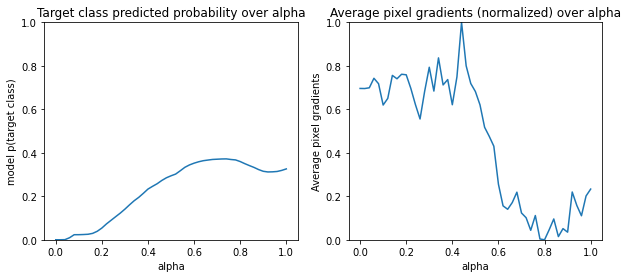

In [21]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [22]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [23]:
ig = integral_approximation(gradients=path_gradients)

In [31]:
print(ig.shape)

(224, 224, 3)


In [25]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.    
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Stack path gradients together row-wise into single tensor.
    total_gradients = tf.stack(gradient_batch)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [26]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [27]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

In [28]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                        image=image,
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return attribution_mask

In [29]:
img_name_tensors.keys()

dict_keys(['Fireboat', 'Giant Panda'])

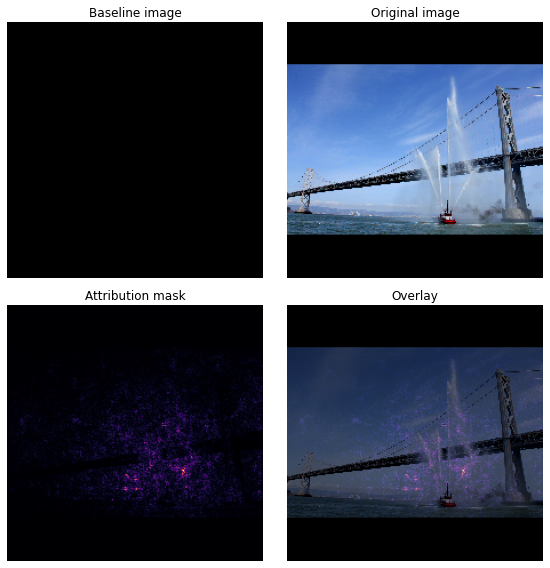

In [30]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [31]:
import sys
sys.path.append("/home/ailie/Repos/BBAttacks/attacks/")
sys.path.append("/home/ailie/Repos/BBAttacks/utils/")

import utils
from data_manager import load_data

# Black Box Attacks
import random_noise
import EvoStrategy
import SimbaWrapper

In [84]:
attacked_model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
    tf.keras.layers.Softmax(axis=1)
])


___________________
Correct label: 555
Initial class: 555
Initial probability to be classified correctly: 0.32604745
After 6 generations
Label: 555 ; Prediction: 719
Fitness: 0.84134793


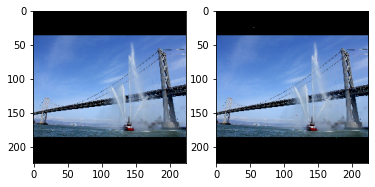


Final probability to be classified correctly: 0.15865181
Final probability to be classified as: 719  is  0.18688104
Queries:  91
_________________________

PERTURBED


In [121]:
img = img_name_tensors['Fireboat'].numpy()

label = 555
adv_evo_strategy = EvoStrategy.AdversarialPerturbationEvoStraegy(
    model=attacked_model,
    img=img,
    label=label,
    generation_size=15, 
    one_step_perturbation_pixel_count=1,
    verbose=True,
    zero_one_scale=True,
    range_scale_int=True,
#         max_rand=int(x_val.max()),
#         min_rand=int(x_val.min())
    # preprocess = preprocess_input
)

no_steps = adv_evo_strategy.run_adversarial_attack(steps=1000)

if adv_evo_strategy.stop_criterion() and no_steps > 0:
    print("PERTURBED")

In [122]:
imagenet_labels[719]

'pier'

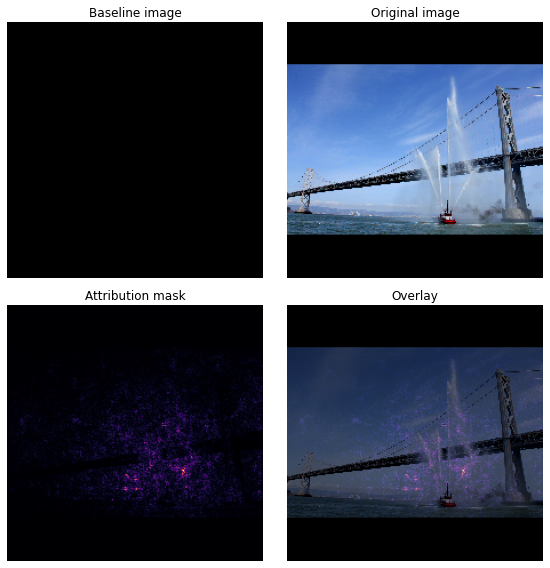

In [129]:
mask = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

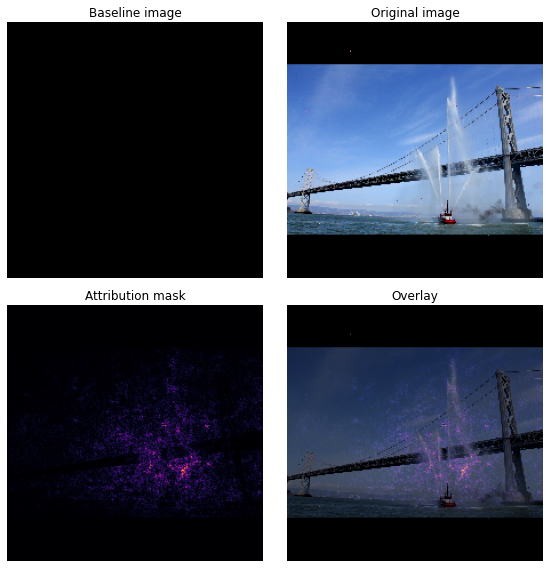

In [130]:
mask_perturbed = plot_img_attributions(image=adv_evo_strategy.get_best_candidate(),
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [205]:
from tensorflow.keras.utils import to_categorical

In [167]:
x_val_raw = np.load("/home/ailie/Repos/BBAttacks/data/x_val_0_10000.npy") # loaded as RGB
x_val_raw = x_val_raw / 255

In [210]:
y_val = np.load("/home/ailie/Repos/BBAttacks/data/y_val.npy")
y_val += 1

In [227]:
imagenet_labels[484]

'castle'


___________________
Correct label: 484
Initial class: 484
Initial probability to be classified correctly: 0.86234796
After 51 generations
Label: 484 ; Prediction: 744
Fitness: 0.8817441


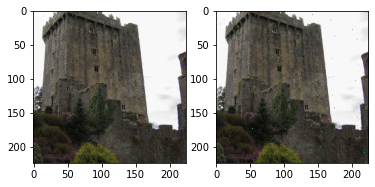


Final probability to be classified correctly: 0.11825592
Final probability to be classified as: 744  is  0.12524661
Queries:  766
_________________________

PERTURBED


In [225]:
idx = 121
img = x_val_raw[idx]

label = y_val[idx]
adv_evo_strategy = EvoStrategy.AdversarialPerturbationEvoStraegy(
    model=attacked_model,
    img=img,
    label=label,
    generation_size=15, 
    one_step_perturbation_pixel_count=1,
    verbose=True,
    zero_one_scale=True,
    range_scale_int=True,
#         max_rand=int(x_val.max()),
#         min_rand=int(x_val.min())
    # preprocess = preprocess_input
)

no_steps = adv_evo_strategy.run_adversarial_attack(steps=1000)

if adv_evo_strategy.stop_criterion() and no_steps > 0:
    print("PERTURBED")

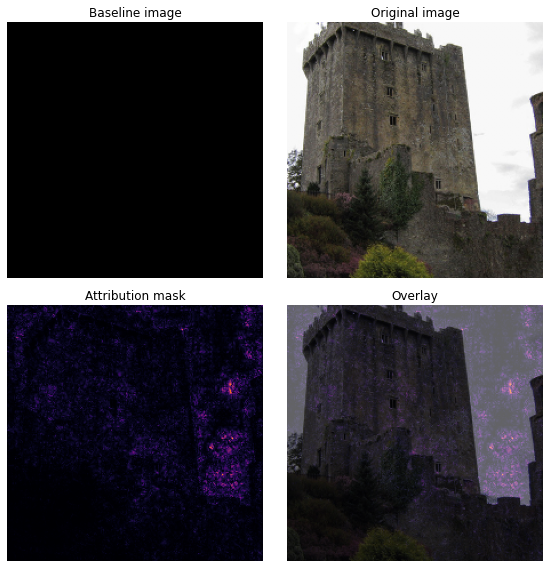

In [229]:
mask = plot_img_attributions(image=x_val_raw[idx],
                          baseline=baseline,
                          target_class_idx=y_val[idx],
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

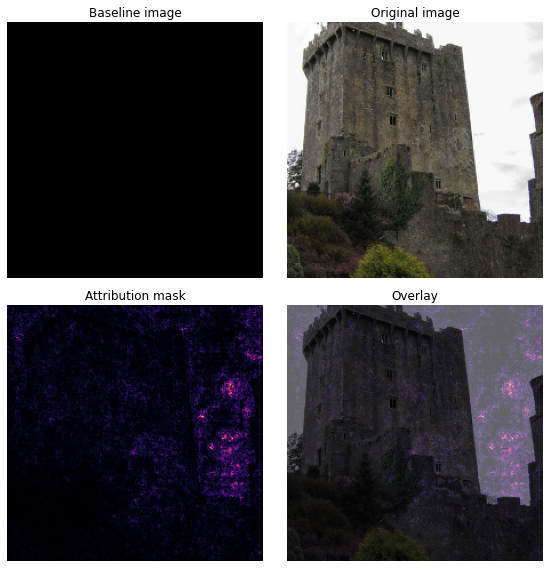

In [230]:
mask = plot_img_attributions(image=x_val_raw[idx],
                          baseline=baseline,
                          target_class_idx=744,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)